In [43]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int, Smooth
from spec_extract import Scale_spectra
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [2]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')
lzDB = galDB.query('z_grism < 1.5')
mzDB = galDB.query('1.5 < z_grism < 1.8')
hzDB = galDB.query('1.8 < z_grism < 2.1')
uhzDB = galDB.query('2.1 < z_grism')

lwa = np.load('../data/light_weight_scaling_3.npy')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
BFs = pd.read_pickle('../dataframes/BF_fit_all.pkl')

In [4]:
bfZ, bfd, bft, bftau, bfz, gids = [[],[],[],[],[],[]]

for i in BFs.index:
    bfZ.append(BFs.bfZ[i])
    bft.append(BFs.bft[i])
    bftau.append(BFs.bftau[i])
    bfz.append(np.round(BFs.bfz[i],3))
    bfd.append(np.round(BFs.bfd[i],1))
    gids.append(int(BFs.gids[i]))
    
bfZ = np.array(bfZ)
bft = np.array(bft)
bftau = np.array(bftau)
bfz = np.array(bfz)
bfd = np.array(bfd)
gids = np.array(gids)

In [25]:
wv = []
res = []
nerr = []

for i in galDB.index:
#     print(bfZ[gids == galDB.ids[i]][0], bft[gids == galDB.ids[i]][0],bftau[gids == galDB.ids[i]][0],
#                         bfz[gids == galDB.ids[i]][0], bfd[gids == galDB.ids[i]][0])
    sp = Gen_spec(galDB.field[i], galDB.ids[i], galDB.z_grism[i], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[i]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[i]))[0], g102_lims=[8500,11300])   
    
    if bftau[gids == galDB.ids[i]][0] == 0:
        BFTAU  = int(0)
    else:
        BFTAU = bftau[gids == galDB.ids[i]][0]
    
    sp.Sim_phot(bfZ[gids == galDB.ids[i]][0], bft[gids == galDB.ids[i]][0],BFTAU,
                        bfz[gids == galDB.ids[i]][0], bfd[gids == galDB.ids[i]][0])
    wv.extend(sp.Pwv_rf)
    res.extend((sp.Pflx - sp.Pmfl) / sp.Pflx)
    nerr.extend(sp.Perr / sp.Pflx)    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/V

In [45]:
wave = np.array(wv)[IDW]
tmp_err = np.sqrt(np.array(res)**2 - np.array(nerr)**2)[IDW]

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [48]:
wave = wave[tmp_err**2 > 0]
tmp_err = tmp_err[tmp_err**2 > 0]

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


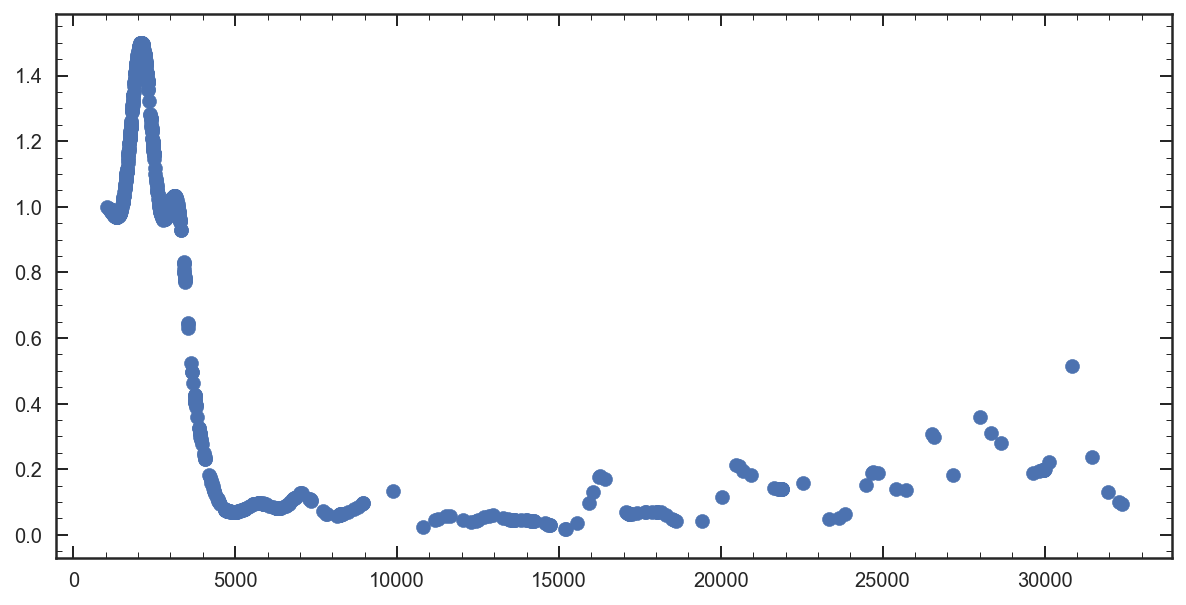

In [50]:

plt.figure(figsize=[10,5])
plt.scatter(wave,Smooth(tmp_err,wave))
# plt.ylim(-6E-39,30E-38)

In [39]:
IDW =np.array(wv).argsort()

In [35]:
wv

[4545.852745758825,
 1060.6682300255413,
 1273.0361411063243,
 1310.999810294614,
 1401.387997445114,
 1615.3207683591627,
 1730.5004850368632,
 1920.900337239517,
 2009.6006077618226,
 2350.7713660504473,
 2270.498984636417,
 2688.012076811331,
 2665.386100630971,
 3674.77601436636,
 3701.139114140218,
 4095.546501442228,
 4828.823396640992,
 6378.666141849892,
 10494.46198078395,
 13277.80594965009,
 16927.517830233886,
 23181.838202090785,
 6170.1546312007895,
 1439.6610180049263,
 1727.911193133465,
 1779.4398550502071,
 1902.1251074646923,
 2192.4992904939295,
 2348.8344605986704,
 2607.267057418752,
 2727.661275085081,
 3190.7375012670286,
 3081.7825848541743,
 3648.4794145465726,
 3617.768835140996,
 4987.829019499682,
 5023.612053236145,
 5558.947160518656,
 6554.234972048491,
 8657.859952181312,
 14244.291844496556,
 18022.166676836172,
 22975.975768770048,
 31465.059328159423,
 4739.532177347194,
 1105.8587875258586,
 1327.2747911441988,
 1366.8559306467782,
 1461.09517362524